In [4]:
%matplotlib inline

from gamesopt.train_distributed import train, TrainDistributedConfig
from gamesopt.games import GameOptions, QuadraticGameConfig, GameType
from gamesopt.optimizer import OptimizerOptions, OptimizerType
from gamesopt.aggregator import AggregationOptions, AggregatorType
from gamesopt.attacks import AttackOptions, AttackType
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TrainDistributedConfig(game=GameOptions(game_type=<GameType.QUADRATIC: 'quadratic'>, quadratic_options=QuadraticGameConfig(num_samples=500, dim=10, num_players=2, bias=True, sigma=0.1, mu=0.01, ell=100.0, seed=0, matrix=None)), optimizer=OptimizerOptions(optimizer_type=<OptimizerType.SGDARA: 'SGDARA'>, lr=0.005, alpha=0.8, batch_size=10, aggregation_options=AggregationOptions(n_total=20, n_byzan=4, aggregator_type=<AggregatorType.RFA: 'RFA'>, use_bucketing=True, bucketing_s=2, clipping_tau=102, clipping_n_iter=1, trimmed_mean_b=10, krum_m=2, rfa_T=10, rfa_nu=0.1), attack_options=AttackOptions(n_total=20, n_byzan=4, n_attacking=9, attack_type=<AttackType.ALIE: 'ALittleIsEnough'>, rn_sigma=10.0, ipm_epsilon=0.01, alie_z=None), sigmaC=100.0, lr_inner=0.004999500049995, lr_outer=0.00124987501249875), num_iter=200, n_process=20)


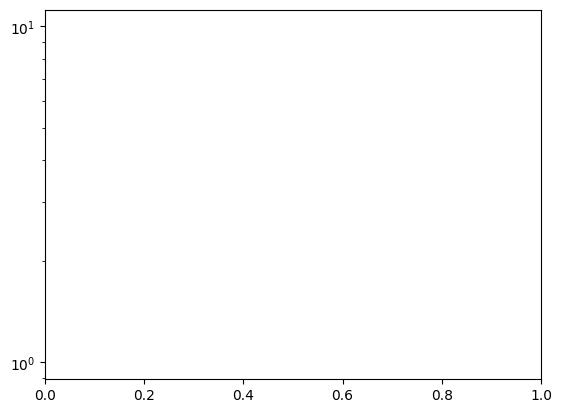

In [2]:
n_iter = 200

n_total = 20
n_byzan = 4

num_samples = 500
dim = 10
bias = True
sigma = 1e-1  # actually scales sigma
mu = 1e-2
ell = 1e2

attack_type = AttackType.ALIE
n_attacking = 9
ipm_epsilon = 1e-2
rn_sigma = 10.


use_bucketing = True
bucketing_s = 2
aggregator_type = AggregatorType.RFA
trimmed_mean_b = 10
krum_m = 2
clipping_tau = 102
clipping_n_iter = 1
rfa_T: int = 10
rfa_nu: int = 0.1

optimizer_type = OptimizerType.SGDARA
# optimizer_type = OptimizerType.MSGDARA
# optimizer_type = OptimizerType.SEGDARA
alpha = 0.8
lr = 1/2/ell
lr_inner = 1/2/(ell+mu)
lr_outer = lr_inner/4
batch_size = 10
sigmaC = 100.

aggregation_options = AggregationOptions(n_total=n_total,
                                         n_byzan=n_byzan,
                                         aggregator_type=aggregator_type,
                                         use_bucketing=use_bucketing,
                                         bucketing_s=bucketing_s,
                                         trimmed_mean_b=trimmed_mean_b,
                                         krum_m=krum_m,
                                         clipping_tau=clipping_tau,
                                         clipping_n_iter=clipping_n_iter,
                                         rfa_T=rfa_T,
                                         rfa_nu=rfa_nu)

quadratic_game_options = QuadraticGameConfig(num_samples=num_samples,
                                             dim=dim,
                                             num_players=2,
                                             bias=bias,
                                             sigma=sigma,
                                             mu=mu,
                                             ell=ell)

game_options = GameOptions(GameType.QUADRATIC, quadratic_game_options)

attack_options = AttackOptions(n_total=n_total,
                               n_byzan=n_byzan,
                               n_attacking=n_attacking,
                               attack_type=attack_type,
                               ipm_epsilon=ipm_epsilon,
                               rn_sigma=rn_sigma)

optimizer_options = OptimizerOptions(optimizer_type=optimizer_type,
                                     lr=lr,
                                     batch_size=batch_size,
                                     aggregation_options=aggregation_options,
                                     attack_options=attack_options,
                                     sigmaC=sigmaC,
                                     alpha=alpha,
                                     lr_inner=lr_inner,
                                     lr_outer=lr_outer)

config = TrainDistributedConfig(game=game_options,
                                optimizer=optimizer_options,
                                num_iter=n_iter,
                                n_process=n_total)
print(config)
plt.figure()
plt.yscale('log')

Trying port 11693
Matrix generated
Bias generated
Solution found
Trying port 41412
Matrix generated
Bias generated
Solution found
Trying port 17768
Matrix generated
Bias generated
Solution found


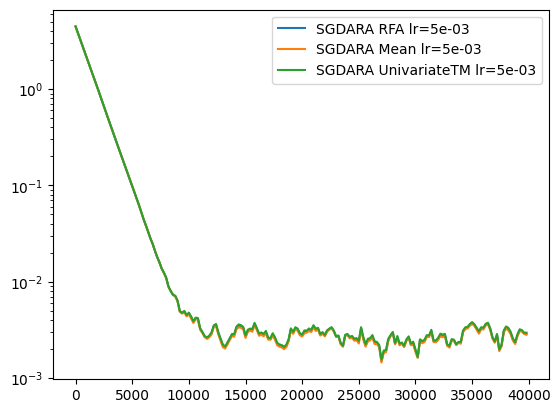

In [3]:
plt.figure()
plt.yscale('log')
config.optimizer.optimizer_type =  OptimizerType.SGDARA
for a_t in [AggregatorType.RFA,AggregatorType.Mean,AggregatorType.UnivariateTM]:
        # config.optimizer.optimizer_type =  OptimizerType.SEGRA
        config.optimizer.aggregation_options.aggregator_type = a_t
        record = train(config)

        record.load_metrics()

        plt.plot(record.metrics.num_grad, record.metrics.dist,
        label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                config.optimizer.aggregation_options.aggregator_type.value,
                                config.optimizer.lr))
plt.legend()
plt.show()

Trying port 44796
Matrix generated
Bias generated
Solution found


[4.471138000488281, 4.299063205718994, 4.133828163146973]

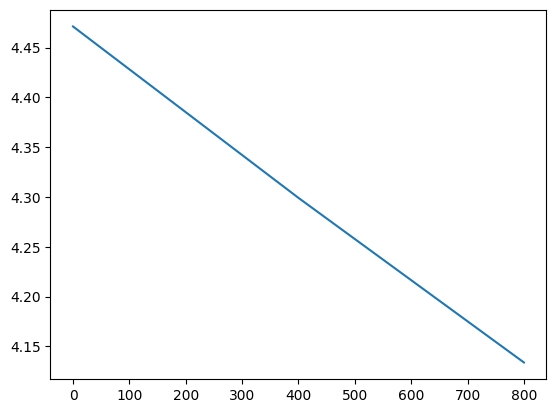

In [14]:
config.optimizer.optimizer_type =  OptimizerType.SEGRA
config.optimizer.aggregation_options.aggregator_type = AggregatorType.Mean
record = train(config)

record.load_metrics()

plt.plot(record.metrics.num_grad, record.metrics.dist,
        label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                config.optimizer.aggregation_options.aggregator_type.value,
                                config.optimizer.lr))
record.metrics.dist

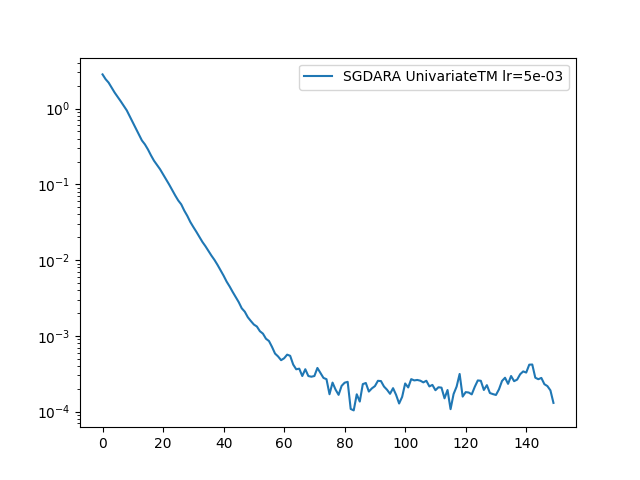

In [63]:
plt.figure()
plt.yscale('log')
record.load_metrics()
# plt.figure()
plt.plot(record.metrics.n_iter, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))
plt.yscale('log')
plt.legend()
plt.show()

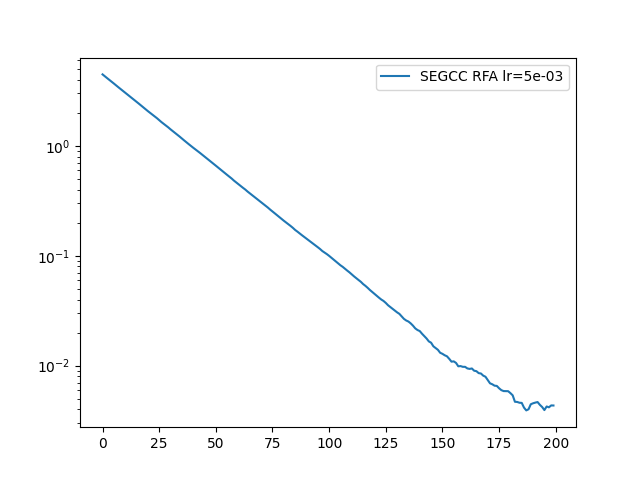

In [ ]:
plt.figure()
plt.yscale('log')
record.load_metrics()
# plt.figure()
plt.plot(record.metrics.n_iter, record.metrics.dist,
         label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                 config.optimizer.aggregation_options.aggregator_type.value,
                                 config.optimizer.lr))
plt.yscale('log')
plt.legend()
plt.show()

Trying port 18391
Matrix generated
Bias generated
Solution found
Trying port 24794
Matrix generated
Bias generated
Solution found
Trying port 30793
Matrix generated
Bias generated
Solution found


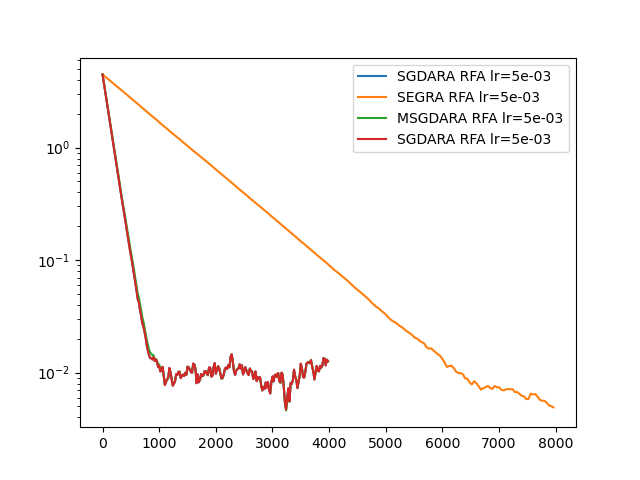

In [ ]:
for o_t in [OptimizerType.SEGRA, OptimizerType.MSGDARA, OptimizerType.SGDARA]:
    config.optimizer.optimizer_type = o_t
    record = train(config)

    plt.yscale('log')
    record.load_metrics()
    # plt.figure()
    plt.plot(record.metrics.num_grad, record.metrics.dist,
            label="%s %s lr=%.e" % (config.optimizer.optimizer_type.value,
                                    config.optimizer.aggregation_options.aggregator_type.value,
                                    config.optimizer.lr))
    plt.yscale('log')
    plt.legend()
plt.show()